In [12]:
import numpy as np 


from cfl.cluster_methods.kmeans import KMeans
from cfl.experiment import Experiment
from visual_bars import generate_visual_bars_data as vbd
from cfl.util.data_processing import one_hot_encode
from cfl.dataset import Dataset

In [2]:
# create a visual bars data set 

n_samples = 10000
noise_lvl = 0.03
im_shape = (10, 10)
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl)

x = vb_data.getImages()
y = vb_data.getTarget()
 
# format data 
x = np.reshape(x, (n_samples, np.prod(im_shape)))
y = one_hot_encode(y, unique_labels=[0,1])

Generating a visual bars dataset with 10000 samples at noise level 0.03


In [3]:
print(x.shape)
print(y.shape)

(10000, 100)
(10000, 2)


All results from this run will be saved to C:/Users/yumen/Documents/Schmidt Academy/cfl/vb_k_test\experiment0009
opt_config not specified in input, defaulting to {}
verbose not specified in input, defaulting to 1
dense_units not specified in input, defaulting to [50, 2]
activations not specified in input, defaulting to ['relu', 'linear']
dropouts not specified in input, defaulting to [0, 0]
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
name not specified in input, defaulting to CondExpVB
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True
Training CFL pipeline.
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 4s 481us/sample - loss: 1.5896 - val_loss: 0.2361
Epoch 2/30
7500/7500 [==============================] - 1s 179us/sample - loss: 0.5806 - val_loss: 0.

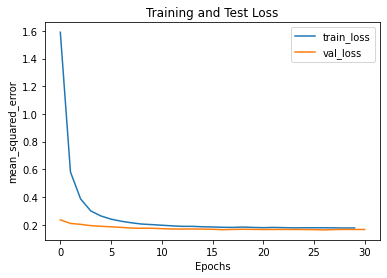

Saving parameters to  C:/Users/yumen/Documents/Schmidt Academy/cfl/vb_k_test\experiment0009\trained_blocks\CondExpVB


In [4]:
# create a CDE-only experiment with visual bars data and train 
data_info = { 'X_dims' : x.shape, 
              'Y_dims' : y.shape, 
              'Y_type' : 'categorical' } 

# CDE parameters
CDE_params = {  'batch_size': 32,
                    'optimizer': 'adam', 
                    'n_epochs': 30, 
                 }
                            
block_names = ['CondExpVB']
block_params = [CDE_params]

# save_path = '/Users/imanwahle/Desktop/cfl/examples/exp_results'
save_path = 'C:/Users/yumen/Documents/Schmidt Academy/cfl/vb_k_test'
my_exp = Experiment(X_train=x, Y_train=y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, results_path=save_path)


In [5]:
# load the CDE results  
import joblib
import os
cde_results_dict = joblib.load(os.path.join('/', save_path, 'experiment0007/dataset_train/CondExpVB_results.pickle'))

pyx = cde_results_dict['pyx']
# load CondExpVB_results 
# format is a results dict 
# want the [pyx] from the results 

In [6]:
# pyx is an array n_samples long
# where the first entry in each row is P(y=0 | X=x) and the 
# second entry is P(y=1 | X=x) 
# (the first and second entry of each row roughly add up to 1)
pyx.shape
pyx[:10]

array([[0.4968367 , 0.5029416 ],
       [0.5428738 , 0.45675695],
       [0.04811791, 0.95084274],
       [0.44256657, 0.55704117],
       [0.0821687 , 0.91722846],
       [0.7752958 , 0.2248357 ],
       [0.81293213, 0.18709275],
       [0.36047077, 0.63877225],
       [0.13486803, 0.86466295],
       [0.23128805, 0.7679382 ]], dtype=float32)

In [11]:
# create a number of Kmeans objects with different Ks 
k_range = range(2, 5)

kmeans_l = []
for n_clusters in k_range:
    params = {'n_Xclusters': n_clusters, 'n_Yclusters': 2} 
    kmeans_obj = KMeans('Kmeans', data_info, params, random_state=143)
    kmeans_l.append(kmeans_obj)

In [17]:
data = Dataset(x, y)

# trained all the data on the kmeanss 
results_l = []
for kmeans_obj in kmeans_l: 
  cluster_results = kmeans_obj.train(data, cde_results_dict)
  results_l.append(cluster_results['x_lbls'])